# PyDate Johannesburg Meetup
## Model Evaluation & Validation
##  Predicting Capetown Southern Suburbs Housing Prices
### Notebook by [Alpha Hamadou Ibrahim](https://za.linkedin.com/in/alphaibrahim)


## Introduction

Model selection and evaluation are crucial parts of every data science project. Knowing what model to use given a problem, tuning the model and evaluating it with an appropriate metric are indispensable skills that a data scientist should have.
The aim of this notebook is to illustrate the concepts of model selection, evaluation and hyper-parameters tuning using a simple model.  The model  has been trained to predict the monetary value of a home on data collected in South African suburbs.


## Data exploration

It is aways a good idea to do some exploratory data analysis to understand the data set at hand. In the next cell, we are going to import the necessary libraries and load the data set that will be used for the analysis.

In [54]:
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")

# Import libraries necessary for this project
import numpy as np
import pandas as pd
import visuals as vs # Supplementary code
from sklearn.cross_validation import ShuffleSplit

# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

# Load the housing dataset
data = pd.read_csv('Southern_Suburb_Housing_Prices.csv')
#prices = data['MEDV']
#features = data.drop('MEDV', axis = 1)
    
# Success
print "Housing dataset has {} data points with {} variables each.".format(*data.shape)

Housing dataset has 2939 data points with 24 variables each.


The dataset contains information about 2939 properties. Lets display the first five rows of the data to get an idea of the type of variables it contains.

In [55]:
data.head()

,region,area,suburb,subsuburb,type,land_size,dwell_size,condition,property_age,beds,...,pbays,pool,staff,buyer_source,buyer_origin_country,buyer_origin_region,finance_type,list_price,sales_price,value_of_thing
0,Western Cape,Southern Suburbs,Athlone,none,APRT,50.0,50.0,Fair,6.0,2.0,...,1.0,0,0,Website,South Africa,Western Cape,Bond,499000.0,480000.0,120
1,Western Cape,Southern Suburbs,Athlone,none,APRT,60.0,60.0,Fair,5.0,2.0,...,1.0,0,0,Referral,South Africa,Western Cape,Cash,440000.0,365000.0,44
2,Western Cape,Southern Suburbs,Athlone,none,APRT,92.0,92.0,Good,7.0,3.0,...,0.0,0,0,Press - Advertisement,South Africa,Western Cape,Bond,500000.0,460000.0,120
3,Western Cape,Southern Suburbs,Athlone,none,DS HSE,505.0,72.0,Good,56.0,3.0,...,0.0,0,0,Telephone,South Africa,Western Cape,Cash,950000.0,920000.0,4
4,Western Cape,Southern Suburbs,Athlone,none,SS HSE,217.0,74.0,Good,38.0,2.0,...,0.0,0,0,Website,South Africa,Western Cape,Bond,650000.0,620000.0,7


In order to have an idea of the distribution of the properties with respect to the different attributes, I am plotting the the number of properties with against some of the variables.

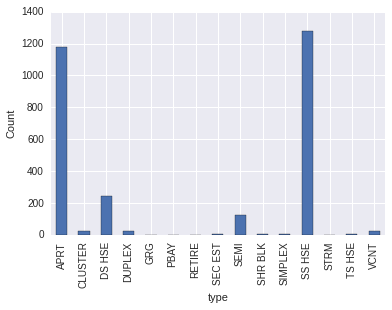

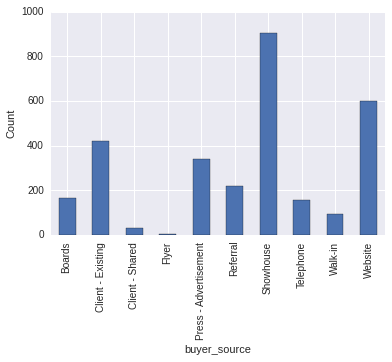

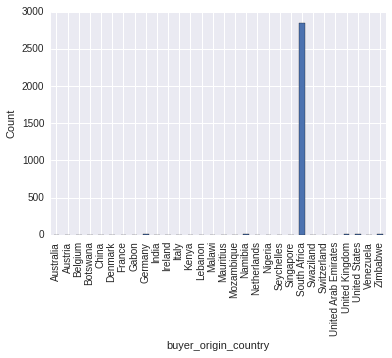

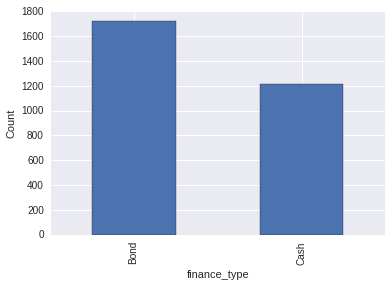

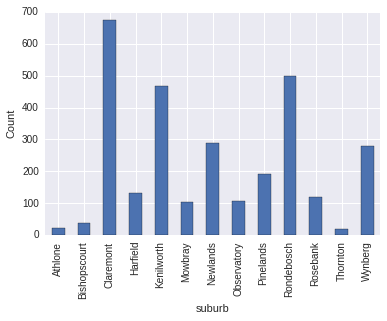

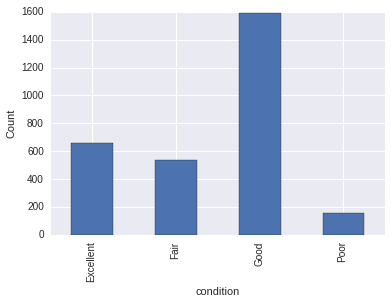

In [56]:
data[['type','land_size']].groupby('type').count().plot(kind='bar', legend=False).set_ylabel("Count")
data[['buyer_source','land_size']].groupby('buyer_source').count().plot(kind='bar', legend=False).set_ylabel("Count")
data[['buyer_origin_country','land_size']].groupby('buyer_origin_country').count().plot(kind='bar', legend=False).set_ylabel("Count")
data[['finance_type','land_size']].groupby('finance_type').count().plot(kind='bar', legend=False).set_ylabel("Count")
data[['suburb','land_size']].groupby('suburb').count().plot(kind='bar', legend=False).set_ylabel("Count")
data[['condition','land_size']].groupby('condition').count().plot(kind='bar', legend=False).set_ylabel("Count")

I would also be interesting to see the distrubution of the properties as a function of the sale price. For that, I am going to create buckets to group prices. For example all properties with a price between 0 and R1 000 000 will be part of bucket '0 - 1M'.

In [57]:
# Create the different bins
bins = [0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000, 40000000]
names = ['0 -1M', '1M - 2M', '2M - 3M', '3M - 4M', '4M - 5M', '5M - 6M', '6M - 7M', '7M - 8M',  '8M - 9M', '9M - 10M', '10M+']

data['price_bins'] = pd.cut(data['sales_price'], bins, labels=names)
data.head()

,region,area,suburb,subsuburb,type,land_size,dwell_size,condition,property_age,beds,...,pool,staff,buyer_source,buyer_origin_country,buyer_origin_region,finance_type,list_price,sales_price,value_of_thing,price_bins
0,Western Cape,Southern Suburbs,Athlone,none,APRT,50.0,50.0,Fair,6.0,2.0,...,0,0,Website,South Africa,Western Cape,Bond,499000.0,480000.0,120,0 -1M
1,Western Cape,Southern Suburbs,Athlone,none,APRT,60.0,60.0,Fair,5.0,2.0,...,0,0,Referral,South Africa,Western Cape,Cash,440000.0,365000.0,44,0 -1M
2,Western Cape,Southern Suburbs,Athlone,none,APRT,92.0,92.0,Good,7.0,3.0,...,0,0,Press - Advertisement,South Africa,Western Cape,Bond,500000.0,460000.0,120,0 -1M
3,Western Cape,Southern Suburbs,Athlone,none,DS HSE,505.0,72.0,Good,56.0,3.0,...,0,0,Telephone,South Africa,Western Cape,Cash,950000.0,920000.0,4,0 -1M
4,Western Cape,Southern Suburbs,Athlone,none,SS HSE,217.0,74.0,Good,38.0,2.0,...,0,0,Website,South Africa,Western Cape,Bond,650000.0,620000.0,7,0 -1M


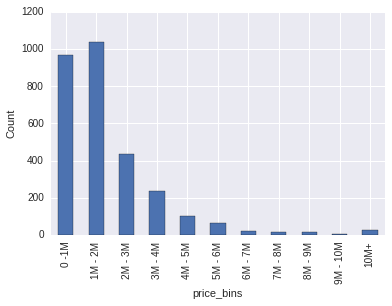

In [58]:
data[['price_bins','land_size']].groupby('price_bins').count().plot(kind='bar', legend=False).set_ylabel("Count")

Since we have both the listed price and the sale price, it would be interesting to see at what percentage of the listed price most properties are sold. For that, I am going to calculate the percentage and put the result into bands like I did with prices above.

In [59]:
#data['price_difference'] = data['list_price'] - data['sales_price']
data['percentage_list_price'] = data['sales_price']/data['list_price']

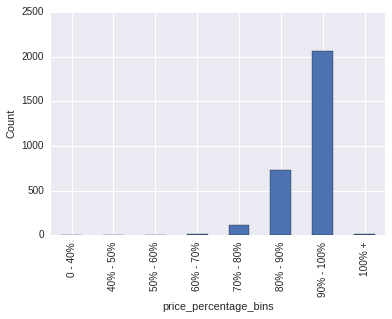

In [60]:
bins = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]
names = ['0 - 40%', '40% - 50%', '50% - 60%', '60% - 70%', '70% - 80%', '80% - 90%', '90% - 100%', '100% +']
#categories = pd.cut(data['sales_price'], bins, labels=names)
data['price_percentage_bins'] = pd.cut(data['percentage_list_price'], bins, labels=names)
data.head()
data[['price_percentage_bins','land_size']].groupby('price_percentage_bins').count().plot(kind='bar', legend=False).set_ylabel("Count")

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.
First I am going to drop all the fields I that I think will not be useful for the prediction.


In [61]:
data.drop(['list_price','region', 'area', 'buyer_source', 'buyer_origin_country','finance_type', 'buyer_origin_region', 'value_of_thing', 'price_bins', 'percentage_list_price', 'price_percentage_bins' ], axis = 1, inplace = True)
data.head()


,suburb,subsuburb,type,land_size,dwell_size,condition,property_age,beds,baths,receptions,studies,garages,pbays,pool,staff,sales_price
0,Athlone,none,APRT,50.0,50.0,Fair,6.0,2.0,1.0,1.0,0.0,0.0,1.0,0,0,480000.0
1,Athlone,none,APRT,60.0,60.0,Fair,5.0,2.0,1.0,2.0,0.0,0.0,1.0,0,0,365000.0
2,Athlone,none,APRT,92.0,92.0,Good,7.0,3.0,2.0,1.0,0.0,0.0,0.0,0,0,460000.0
3,Athlone,none,DS HSE,505.0,72.0,Good,56.0,3.0,3.0,1.0,0.0,2.0,0.0,0,0,920000.0
4,Athlone,none,SS HSE,217.0,74.0,Good,38.0,2.0,1.0,1.0,0.0,0.0,0.0,0,0,620000.0


### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

In the cell below I am separate the  data into feature and target columns to see if any features are non-numeric. Since we are trying to predict the sale price of properties, the target column is *sales_price*.

In [64]:
# Extract feature columns
feature_cols = list(data.columns[:-1])

# Extract target column 'passed'
target_col = data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = data[feature_cols]
y_all = data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['suburb', 'subsuburb', 'type', 'land_size', 'dwell_size', 'condition', 'property_age', 'beds', 'baths', 'receptions', 'studies', 'garages', 'pbays', 'pool', 'staff']

Target column: sales_price

Feature values:
    suburb subsuburb    type  land_size  dwell_size condition  property_age  \
0  Athlone      none    APRT       50.0        50.0      Fair           6.0   
1  Athlone      none    APRT       60.0        60.0      Fair           5.0   
2  Athlone      none    APRT       92.0        92.0      Good           7.0   
3  Athlone      none  DS HSE      505.0        72.0      Good          56.0   
4  Athlone      none  SS HSE      217.0        74.0      Good          38.0   

   beds  baths  receptions  studies  garages  pbays  pool  staff  
0   2.0    1.0         1.0      0.0      0.0    1.0     0      0  
1   2.0    1.0         2.0      0.0      0.0    1.0     0      0  
2   3.0    2.0         1.0      0.0      0.0    0.0     0      0  
3   3.0    3.0         1.0  

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! 

Columns like `type` and `suburb`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `type_APRT`, `type_CLUSTER`, `type_DUPLEX`, etc.), and assign a `1` to one of them and `0` to all others. This transformation is also called *one-hot encoding*.

These generated columns are sometimes called _dummy variables_. I am going to use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [65]:
def preprocess_features(X):
    ''' Preprocesses the data and converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'type' => 'type_APRT' and 'type_DUPLEX'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (53 total features):
['suburb_Athlone', 'suburb_Bishopscourt', 'suburb_Claremont', 'suburb_Harfield', 'suburb_Kenilworth', 'suburb_Mowbray', 'suburb_Newlands', 'suburb_Observatory', 'suburb_Pinelands', 'suburb_Rondebosch', 'suburb_Rosebank', 'suburb_Thornton', 'suburb_Wynberg', 'subsuburb_Claremont Upper', 'subsuburb_Fernwood', 'subsuburb_Hiddingh', 'subsuburb_Kenilworth Upper', 'subsuburb_Lynfrae', 'subsuburb_The Village', 'subsuburb_Wynberg Upper', 'subsuburb_below Belvedere', 'subsuburb_below Rosmead', 'subsuburb_none', 'type_APRT', 'type_CLUSTER', 'type_DS HSE', 'type_DUPLEX', 'type_GRG', 'type_PBAY', 'type_RETIRE', 'type_SEC EST', 'type_SEMI', 'type_SHR BLK', 'type_SIMPLEX', 'type_SS HSE', 'type_STRM', 'type_TS HSE', 'type_VCNT', 'land_size', 'dwell_size', 'condition_Excellent', 'condition_Fair', 'condition_Good', 'condition_Poor', 'property_age', 'beds', 'baths', 'receptions', 'studies', 'garages', 'pbays', 'pool', 'staff']


In [66]:
X_all.head()

,suburb_Athlone,suburb_Bishopscourt,suburb_Claremont,suburb_Harfield,suburb_Kenilworth,suburb_Mowbray,suburb_Newlands,suburb_Observatory,suburb_Pinelands,suburb_Rondebosch,...,condition_Poor,property_age,beds,baths,receptions,studies,garages,pbays,pool,staff
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,2.0,1.0,1.0,0.0,0.0,1.0,0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,2.0,1.0,2.0,0.0,0.0,1.0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,3.0,2.0,1.0,0.0,0.0,0.0,0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,56.0,3.0,3.0,1.0,0.0,2.0,0.0,0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,38.0,2.0,1.0,1.0,0.0,0.0,0.0,0,0



### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, I am going to split the data (both features and corresponding labels) into training and test sets. In the following code cell below,   I will randomly shuffle and split the data (`X_all`, `y_all`) into training (80% of the data) and testing (20% of the data) subsets.

In [67]:
# Import train_test_split
from  sklearn.cross_validation import train_test_split

seed = 0
# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=seed)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 2351 samples.
Testing set has 588 samples.


#### Defining a scoring function

Depending on the problem at hand, one would want to define a scoring metric to optimised to model on. In the cell below, I am defining a funtion that I will use as a scorer to evaluate the model. I am using the R2 or the *coeficient of determination*. But this can be generalised to any metric.

In [68]:
# Import 'r2_score'
from sklearn.metrics import r2_score
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict) 
    
    # Return the score
    return score

#### What model should I use
Choosing an appropriate model for a given problem can be a disficult task. It is a good idea to use the map below [1]. This flowchart is designed to give users a bit of a rough guide on how to approach problems with regard to which estimators to try on your data.

<img src = "ml_map.png" width="1000" height="200">

Since I am trying to predict a quantity (sale_price), I will use an algorithm in the regression quadrant. However, depending on the situation, it might still be unclear what algorithm to use in tha quadrant. In the next cell, I am going to compute the prediction score for a number of these algorighm. I will then choose the algorithm with the best score. This method is not perfect, but it is a quick way to get a rough idea about what algorithm to use.

GB: 0.785057 (0.090029)
RF: 0.803442 (0.079728)
RIDGE: 0.795482 (0.056235)
CART: 0.671375 (0.113846)
LASSO: 0.794522 (0.056379)
ENET: 0.793873 (0.059369)


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


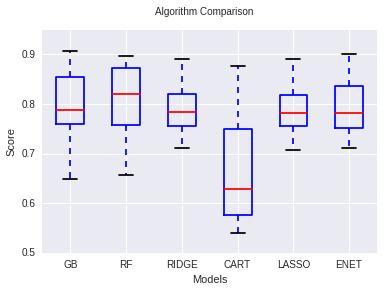

In [69]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import linear_model

# TODO: Initialize the three models
#clf_A = DecisionTreeClassifier(random_state=seed)
#clf_B = ensemble.GradientBoostingClassifier(random_state=seed)
#clf_C = SVC(random_state=seed)

# Compare Algorithms
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
# prepare configuration for cross validation test harness
num_instances = len(X_train)
# prepare models
models = []
#models.append(('LR', LogisticRegression()))
models.append(('GB',ensemble.GradientBoostingRegressor(random_state = 0)))
models.append(('RF',ensemble.RandomForestRegressor(random_state = 0)))
models.append(('RIDGE', linear_model.Ridge (alpha = .5)))
models.append(('CART', DecisionTreeRegressor(random_state = 0)))
models.append(('LASSO', Lasso(alpha=0.1)))
models.append(('ENET',  ElasticNet(alpha=0.1, l1_ratio=0.7)))
# evaluate each model in turn
results = []
names = []


from sklearn.metrics import make_scorer
scoring_func = make_scorer(performance_metric, greater_is_better=True)

for name, model in models:
	kfold = cross_validation.KFold(n=num_instances, n_folds=10, random_state=0)
	cv_results = cross_validation.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring_func)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xlabel('Models')
ax.set_ylabel('Score')
plt.show()

#### Produce learning curves

The Rasmdom forest regressor seem to be the best algorithm to use based on the score computed above. There are three main parameters that we are going to optimse for this algorithm. These are

- n_estimators
- max_depth
- min_samples_leaf    

In the cell below, I am producing a learning curve to see how the algorithm chage as I change the *max_depth* parameter.

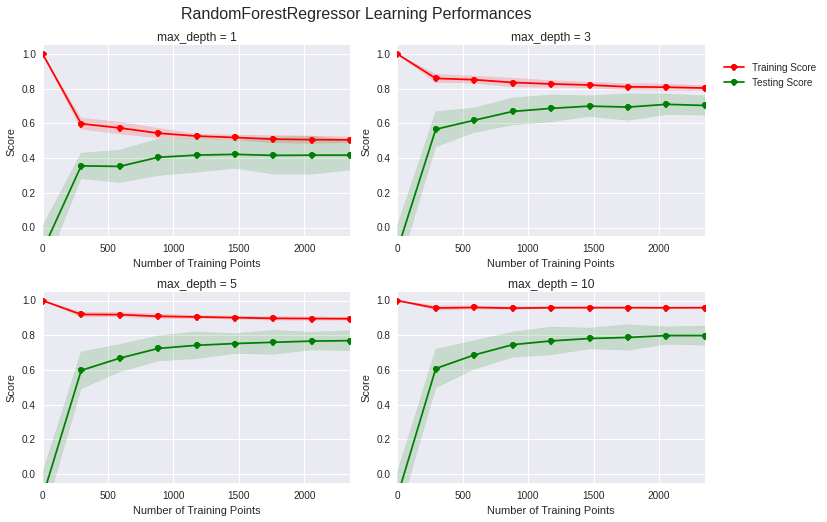

In [70]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(X_all, y_all)

#### Tune hyper-parameters

In [71]:
#from sklearn import grid_search
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over a set of parameters for a 
        random forest regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    print cv_sets
    # Create a random forest regressor object
    regressor = ensemble.RandomForestRegressor(random_state = 0, n_jobs = -1)

    # Create a dictionary for the parameters to search over
    params = {
        'n_estimators': [10, 100, 200],
        'max_depth': range(1,20),
        'min_samples_leaf': [1,5,10]
        
    }

    # ransform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric, greater_is_better=True)

    # Create the grid search object
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)
    
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    #print grid.cv_results_
    #print "best score:", grid.best_score_
    #print "best param:", grid.best_params_
    #print "scorer:", grid.scorer_
    #print "number of splits:", grid.n_splits_
    # Return the optimal model after fitting the data
    return grid.best_estimator_


In [72]:
reg = fit_model(X_train, y_train)        
# Produce the value for parameters
print "Parameters are {} for the optimal model.".format(reg.get_params())

ShuffleSplit(2351, n_iter=10, test_size=0.2, random_state=0)
Parameters are {'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 200, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': 0, 'max_features': 'auto', 'max_depth': 17} for the optimal model.


In [74]:
kfold = cross_validation.KFold(n=len(X_train), n_folds=10, random_state=0)
train_scores = cross_validation.cross_val_score(reg, X_train, y_train, cv=kfold, scoring=scoring_func)

print "the train set score is", train_scores.mean()
print "the test set score is", performance_metric(reg.predict(X_test), y_test)

the train set score is 0.799042048998
the test set score is 0.734967919737


It is useful the display the features importance for the model. That is, how useful were each of the feature to the prediction. I am ploting only the first 11.

                           RF
beds                 0.006510
type_SS HSE          0.006978
pbays                0.012027
suburb_Newlands      0.012233
receptions           0.017744
garages              0.017946
condition_Excellent  0.018461
baths                0.026289
property_age         0.032074
dwell_size           0.344802
land_size            0.464146


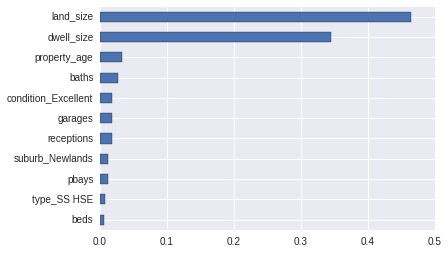

In [75]:
importances = pd.DataFrame()
importances["RF"] = pd.Series(reg.feature_importances_, index = X_all.keys())
importances.sort_values(by= "RF", axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
most_important = importances[importances['RF'] >= 0.006]
print most_important
most_important.plot(kind = "barh", legend=False)

Understandably so, the land size and the size of the house/appartment are the two most important feature for predicting the value of the property.

The plot of the residuals is another way to evalue a predictor. Ideally, the residuals should fall in a symmetrical pattern and have a constant spread throughout the range. 

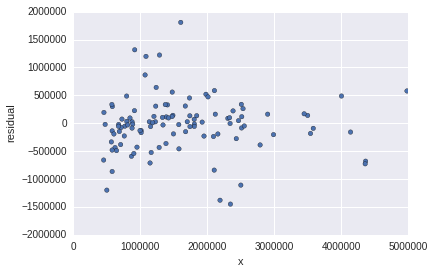

In [78]:
residuals = y_test - reg.predict(X_test)
x = range(0,len(residuals))

len(x)
df = pd.DataFrame()
df['x'] = reg.predict(X_test)
df['y'] = residuals
df.plot(x = 'x', y= 'y', kind='scatter', legend=False, xlim = [0,5e6], ylim = [-2e6,2e6]).set_ylabel("residual")

### References and Further reading

[1] Choosing the right estimator. [ONLINE] Available at: http://scikit-learn.org/stable/tutorial/machine_learning_map/. [Accessed 23 February 2017].

[2] Validation curves: plotting scores to evaluate models. [ONLINE] Available at: http://scikit-learn.org/stable/modules/learning_curve.html. [Accessed 23 February 2017].

[3] Tuning the parameters of your Random Forest model, [ONLINE] Available at: https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/. [Accessed 23 February 2017].

[4] Model evaluation, model selection, and algorithm selection in machine learning. Part I - The basics https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html . [Accessed 23 February 2017].


[5] Model evaluation, model selection, and algorithm selection in machine learning. Part II - Bootstrapping and uncertainties https://sebastianraschka.com/blog/2016/model-evaluation-selection-part2.html . [Accessed 23 February 2017].


[6] Model evaluation, model selection, and algorithm selection in machine learning. Part III -Cross-validation and hyperparameter tuning https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html . [Accessed 23 February 2017].


[7] Approaching (Almost) Any Machine Learning Problem. https://www.linkedin.com/pulse/approaching-almost-any-machine-learning-problem-abhishek-thakur . [Accessed 23 February 2017].


